In [1]:
from google.colab import drive
drive.mount("/content/drive")
import os

Mounted at /content/drive


In [4]:
os.chdir("/content/drive/My Drive/Nova/Mini_Project")
os.getcwd()

'/content/drive/My Drive/Nova/Mini_Project'

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Anomaly Detection Using Auto Encoders

In [120]:
df=pd.read_csv('DailyDelhiClimateTest.csv')
df

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000
110,2017-04-21,34.250000,39.375000,6.962500,999.875000
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


In [121]:
df.shape

(114, 5)

In [122]:
df.columns

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

In [123]:
df['date'].is_unique

True

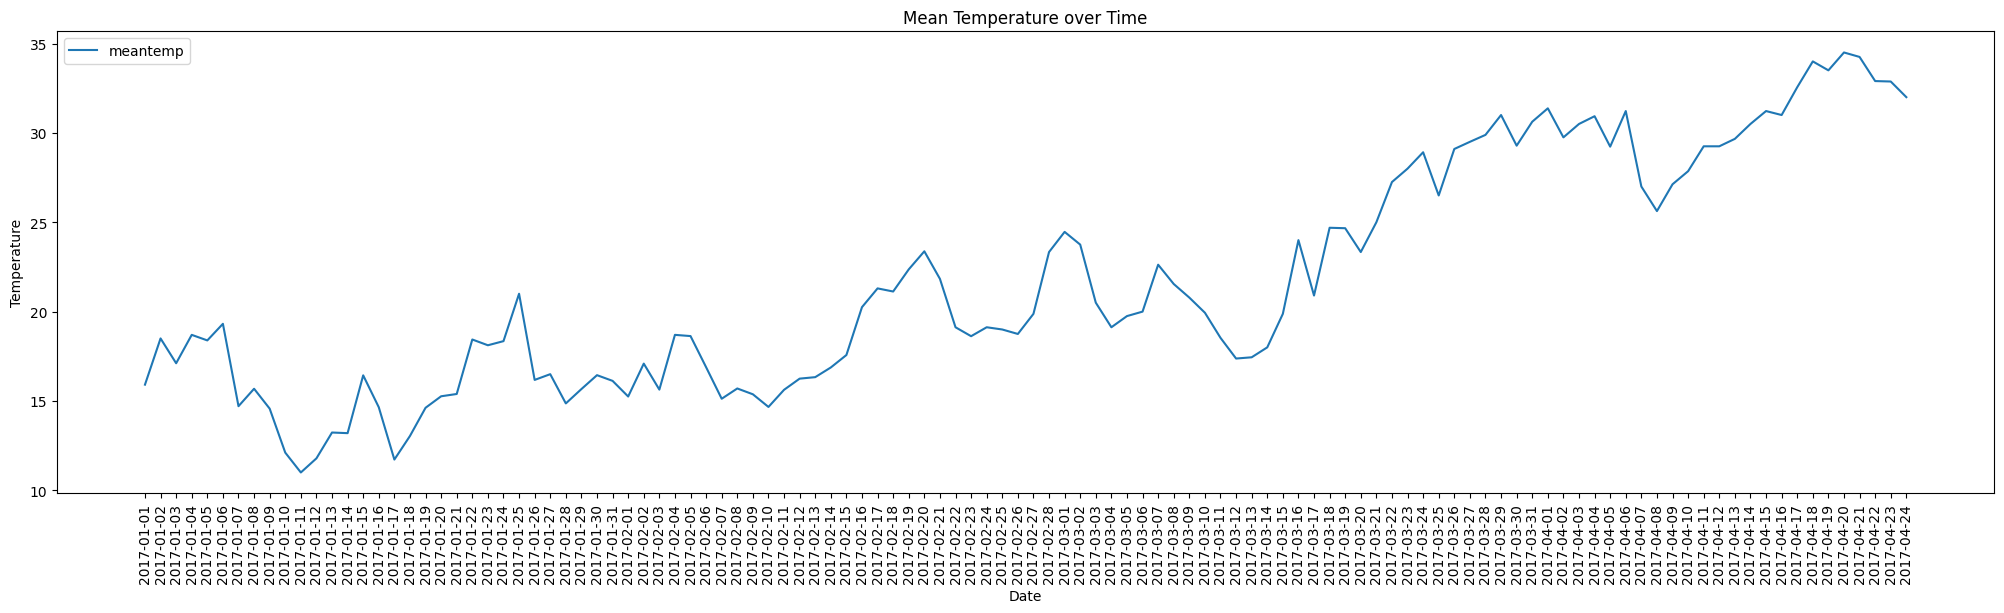

In [124]:
# Reset index to ensure it is unique
#df_reset_index = df.reset_index()
plt.figure(figsize=(25, 6))
# Plot the data
plt.plot(df['date'], df['meantemp'], label='meantemp')
plt.xticks(rotation=90)
# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Mean Temperature over Time')
plt.legend()

# Show plot
plt.show()

In [162]:
train_size = int(len(df) * 0.80)  # 80% of the data for training
test_size = len(df) - train_size  # Remaining 20% for testing

In [163]:
train,test=df.iloc[0:train_size],df.iloc[train_size:len(df)]
print(train.shape,test.shape)

(91, 5) (23, 5)


In [164]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Reshape the input to a 2D array
train_meantemp = train['meantemp'].values.reshape(-1, 1)

# Fit the scaler to the training data
scaler.fit(train_meantemp)


StandardScaler()

In [165]:
train['meantemp'] = scaler.transform(train[['meantemp']])
test['meantemp'] = scaler.transform(test[['meantemp']])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
<ipython-input-165-aab0c44cab18>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['meantemp'] = scaler.transform(train[['meantemp']])
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
<ipython-input-165-aab0c44cab18>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [166]:
train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,-0.733116,85.869565,2.743478,59.000000
1,2017-01-02,-0.194614,77.222222,2.894444,1018.277778
2,2017-01-03,-0.483726,81.888889,4.016667,1018.333333
3,2017-01-04,-0.152982,70.050000,4.545000,1015.700000
4,2017-01-05,-0.217743,74.944444,3.300000,1014.333333


In [167]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [168]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [169]:
TIME_STEPS = 10
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(
  train[['meantemp']],
  train.meantemp,
  TIME_STEPS
)
X_test, y_test = create_dataset(
  test[['meantemp']],
  test.meantemp,
  TIME_STEPS
)
print(X_train.shape)

(81, 10, 1)


In [170]:
import keras
from keras.layers import Input, LSTM, Dropout, RepeatVector, TimeDistributed, Dense
from keras.models import Model

# Define input shape
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Define LSTM layers
lstm1 = LSTM(units=64)(inputs)
dropout1 = Dropout(rate=0.2)(lstm1)
repeat_vector = RepeatVector(n=X_train.shape[1])(dropout1)
lstm2 = LSTM(units=64, return_sequences=True)(repeat_vector)
dropout2 = Dropout(rate=0.2)(lstm2)
output = TimeDistributed(Dense(units=X_train.shape[2]))(dropout2)

# Create the model
model = Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(loss='mae', optimizer='adam')

In [171]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
3/3 [==============================] - 4s 439ms/step - loss: 0.6030 - val_loss: 1.7354
Epoch 2/10
3/3 [==============================] - 0s 24ms/step - loss: 0.5491 - val_loss: 1.5215
Epoch 3/10
3/3 [==============================] - 0s 23ms/step - loss: 0.5124 - val_loss: 1.2952
Epoch 4/10
3/3 [==============================] - 0s 25ms/step - loss: 0.4947 - val_loss: 1.0650
Epoch 5/10
3/3 [==============================] - 0s 25ms/step - loss: 0.4983 - val_loss: 0.8557
Epoch 6/10
3/3 [==============================] - 0s 25ms/step - loss: 0.5032 - val_loss: 0.7110
Epoch 7/10
3/3 [==============================] - 0s 24ms/step - loss: 0.5040 - val_loss: 0.6491
Epoch 8/10
3/3 [==============================] - 0s 29ms/step - loss: 0.4992 - val_loss: 0.6423
Epoch 9/10
3/3 [==============================] - 0s 33ms/step - loss: 0.5010 - val_loss: 0.6567
Epoch 10/10
3/3 [==============================] - 0s 24ms/step - loss: 0.4967 - val_loss: 0.6506


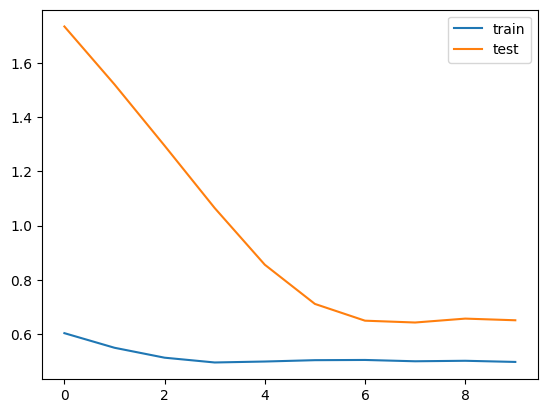

In [172]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()

In [173]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

3/3 [==============================] - 1s 6ms/step


In [174]:
import seaborn as sns

<ipython-input-175-617c2df6feec>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_mae_loss,bins=50,kde=True)


<Axes: ylabel='Density'>

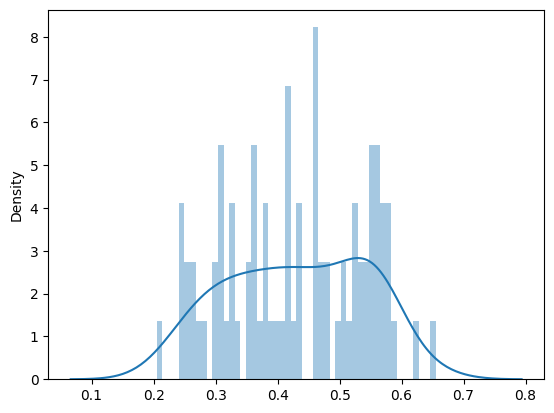

In [175]:
sns.distplot(train_mae_loss,bins=50,kde=True)

In [176]:
THRESHOLD = 0.65

In [177]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

1/1 [==============================] - 0s 20ms/step


In [178]:
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['meantemp'] = test[TIME_STEPS:].meantemp

In [180]:
test_score_df

,loss,threshold,anomaly,meantemp
101,0.896995,0.65,True,2.043110
102,0.939027,0.65,True,2.129844
103,0.914569,0.65,True,2.303311
104,0.820018,0.65,True,2.453649
105,0.749965,0.65,True,2.407391
106,0.566311,0.65,False,2.731196
107,0.538266,0.65,False,3.031872
108,0.572238,0.65,False,2.927792
109,0.586439,0.65,False,3.135952
110,0.575839,0.65,False,3.083912


In [181]:
anomalies = test_score_df[test_score_df.anomaly == True]

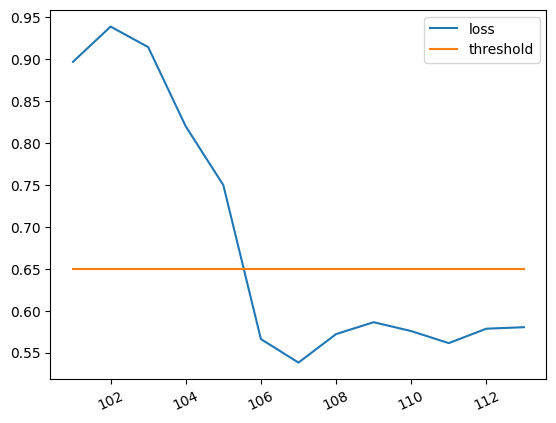

In [182]:
plt.plot(test_score_df.index,test_score_df.loss,label='loss')
plt.plot(test_score_df.index,test_score_df.threshold,label='threshold')
plt.xticks(rotation=25)
plt.legend()

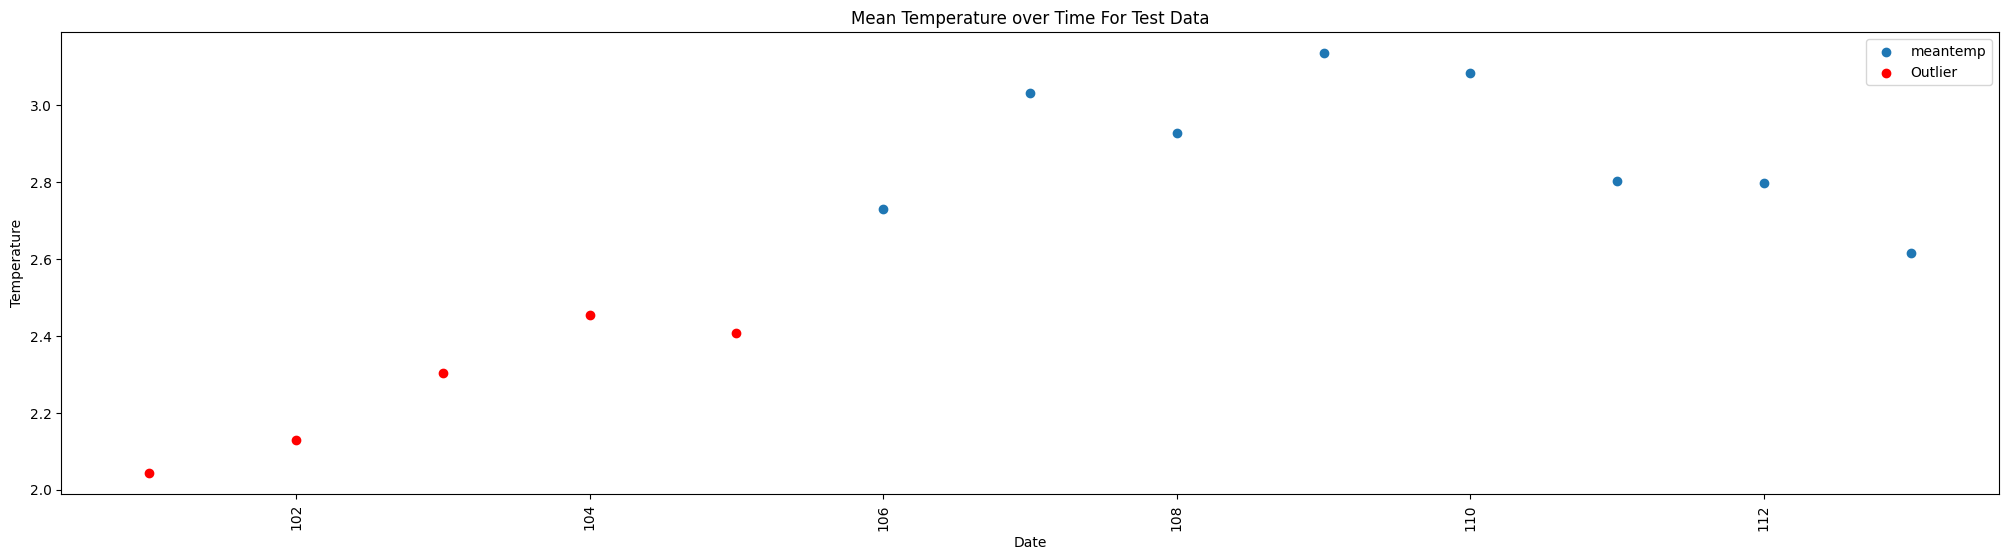

In [188]:
plt.figure(figsize=(25, 6))

plt.scatter(test_score_df['meantemp'][~test_score_df['anomaly']].index, test_score_df['meantemp'][~test_score_df['anomaly']], label='meantemp')
plt.scatter(test_score_df['meantemp'][test_score_df['anomaly']].index, test_score_df['meantemp'][test_score_df['anomaly']],color='red',label="Outlier")
plt.xticks(rotation=90)
# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Mean Temperature over Time For Test Data')
plt.legend()

# Show plot
plt.show()

For Whole Dataset

In [210]:
# X=np.concatenate((X_train,X_test),axis=0)
# X[:5]

In [227]:
df['meantemp']=scaler.transform(df[['meantemp']])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [232]:
TIME_STEPS = 1

X, y = create_dataset(
  df[['meantemp']],
  df.meantemp,
  TIME_STEPS
)
print(X.shape)

(113, 1, 1)


In [233]:
X_pred = model.predict(X)
total_mae_loss = np.mean(np.abs(X_pred - X), axis=1)

4/4 [==============================] - 0s 4ms/step


<ipython-input-234-fc37a15d591d>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(total_mae_loss,bins=50,kde=True)


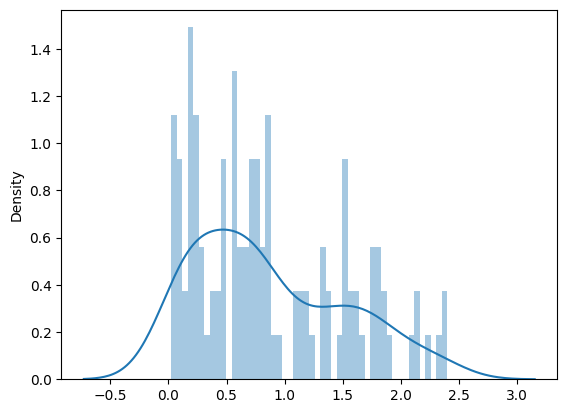

In [234]:
sns.distplot(total_mae_loss,bins=50,kde=True)
plt.show()

In [260]:
THRESHOLD=0.76

In [261]:
total_score_loss = pd.DataFrame(index=df[TIME_STEPS:].index)
total_score_loss['loss'] = total_mae_loss
total_score_loss['threshold'] = THRESHOLD
total_score_loss['anomaly'] = total_score_loss.loss > total_score_loss.threshold
total_score_loss['meantemp'] = df.meantemp

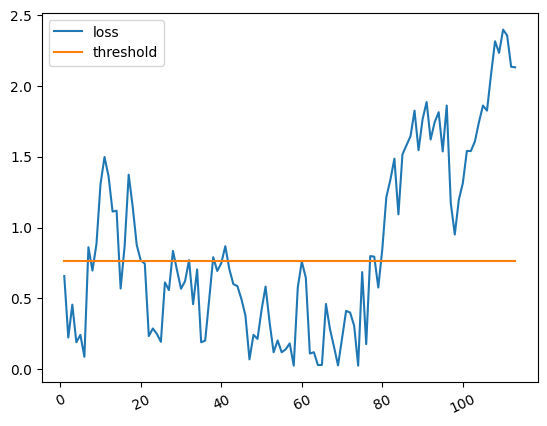

In [262]:
plt.plot(total_score_loss.index,total_score_loss.loss,label='loss')
plt.plot(total_score_loss.index,total_score_loss.threshold,label='threshold')
plt.xticks(rotation=25)
plt.legend()

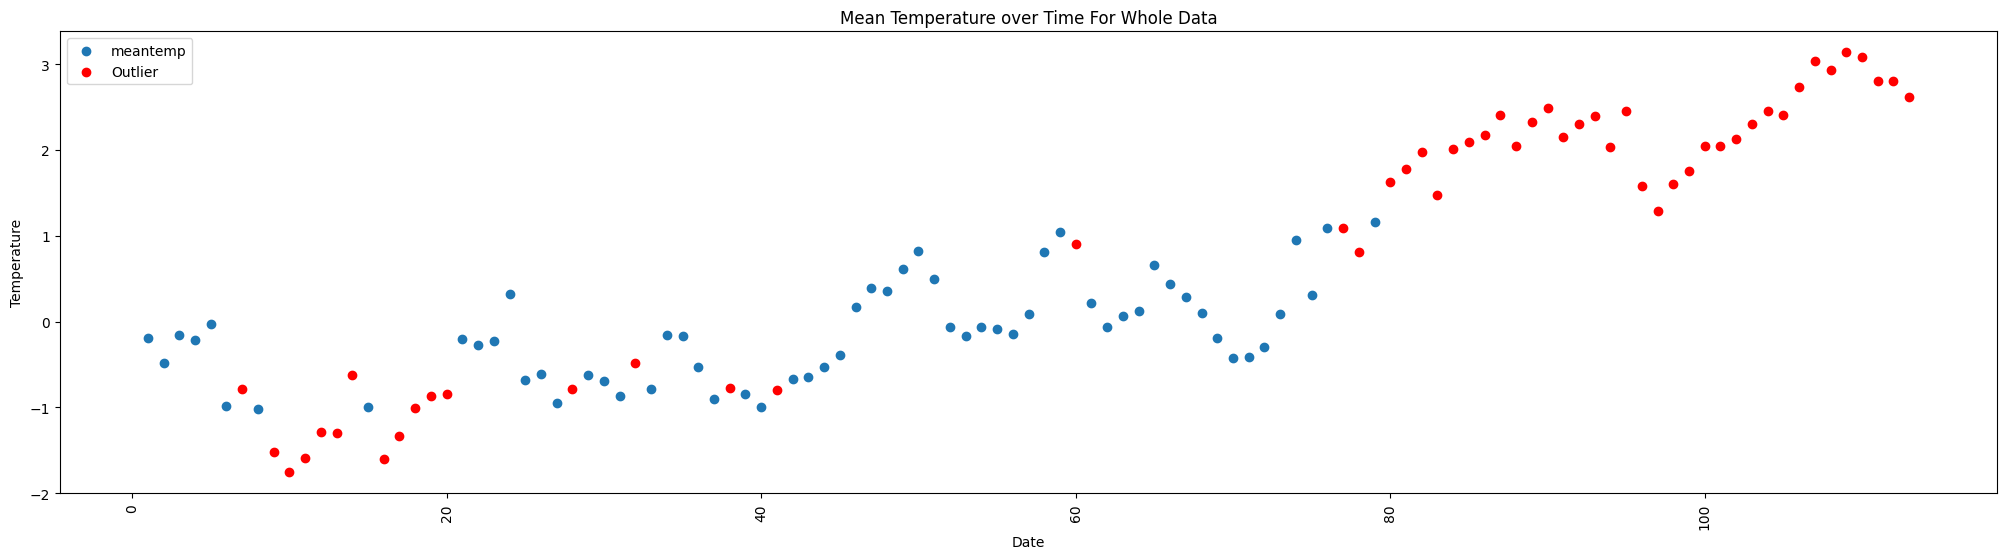

In [263]:
plt.figure(figsize=(25, 6))

plt.scatter(total_score_loss['meantemp'][~total_score_loss['anomaly']].index, total_score_loss['meantemp'][~total_score_loss['anomaly']], label='meantemp')
plt.scatter(total_score_loss['meantemp'][total_score_loss['anomaly']].index, total_score_loss['meantemp'][total_score_loss['anomaly']],color='red',label="Outlier")
plt.xticks(rotation=90)


plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Mean Temperature over Time For Whole Data')
plt.legend()

plt.show()

# Anomaly Detection Using Statistical Methods

In [84]:
df=pd.read_csv("cpu_utilization1.csv")
# df=pd.read_csv("cpu_utilization2.csv")


df['timestamp'] = pd.to_datetime(df['timestamp'])
df

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134
...,...,...
4027,2014-02-28 14:05:00,0.132
4028,2014-02-28 14:10:00,0.134
4029,2014-02-28 14:15:00,0.134
4030,2014-02-28 14:20:00,0.134


In [89]:
anomalies1=[
        "2014-02-26 22:05:00",
        "2014-02-27 17:15:00"
    ]

anomalies2=[
        "2014-02-17 06:12:00",
        "2014-02-22 00:02:00",
        "2014-02-23 15:17:00"
    ]

anomalies=anomalies1    # Select based on Dataset working on

In [90]:
df["isAnomaly"]=1
for i in anomalies:
    df['isAnomaly'][df['timestamp'] == i]=-1
df

<ipython-input-90-ce4e3a1a3155>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['isAnomaly'][df['timestamp'] == i]=-1


,timestamp,value,isAnomaly
0,2014-02-14 14:30:00,0.132,1
1,2014-02-14 14:35:00,0.134,1
2,2014-02-14 14:40:00,0.134,1
3,2014-02-14 14:45:00,0.134,1
4,2014-02-14 14:50:00,0.134,1
...,...,...,...
4027,2014-02-28 14:05:00,0.132,1
4028,2014-02-28 14:10:00,0.134,1
4029,2014-02-28 14:15:00,0.134,1
4030,2014-02-28 14:20:00,0.134,1


In [91]:
df[df['isAnomaly']==-1]

,timestamp,value,isAnomaly
3547,2014-02-26 22:05:00,2.344,-1
3777,2014-02-27 17:15:00,0.602,-1


In [92]:
anomaly_df = df[df['isAnomaly'] == -1]
inlier_df = df[df['isAnomaly'] == 1]

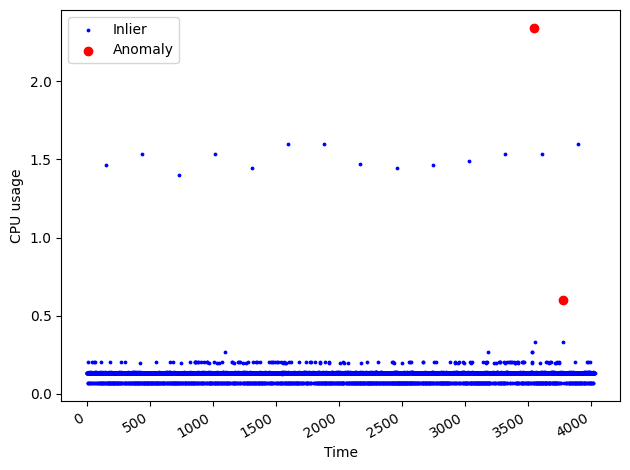

In [93]:
fig, ax = plt.subplots()

ax.scatter(inlier_df.index, inlier_df['value'], color='blue', s=3, label='Inlier')
ax.scatter(anomaly_df.index, anomaly_df['value'], color='red', label='Anomaly')
ax.set_xlabel('Time')
ax.set_ylabel('CPU usage')
ax.legend(loc=2)

plt.grid(False)
fig.autofmt_xdate()
plt.tight_layout()

### Using Median Absolute Deviation (MAD)

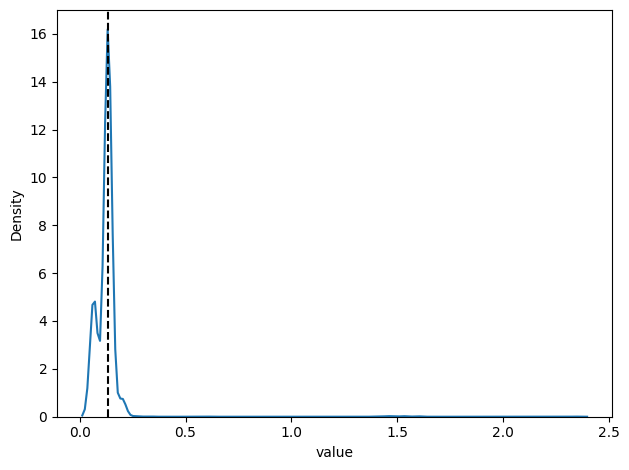

In [94]:
import seaborn as sns

sns.kdeplot(df['value']);
plt.grid(False)
plt.axvline(np.median(df['value']), 0, 1, c='black', ls='--')
plt.tight_layout()

Data not normalised

In [95]:
from scipy.stats import median_abs_deviation

mad = median_abs_deviation(df['value'])
median = np.median(df['value'])

print(median)
print(mad)

def compute_robust_z_score(x):
    return .6745*(x-median)/mad

0.134
0.0020000000000000018


In [96]:
df['z-score'] = df['value'].apply(compute_robust_z_score)

df.head()

,timestamp,value,isAnomaly,z-score
0,2014-02-14 14:30:00,0.132,1,-0.6745
1,2014-02-14 14:35:00,0.134,1,0.0000
2,2014-02-14 14:40:00,0.134,1,0.0000
3,2014-02-14 14:45:00,0.134,1,0.0000
4,2014-02-14 14:50:00,0.134,1,0.0000


In [97]:
df['baseline'] = 1

df.loc[df['z-score'] >= 3.5, 'baseline'] = -1
df.loc[df['z-score'] <=-3.5, 'baseline'] = -1

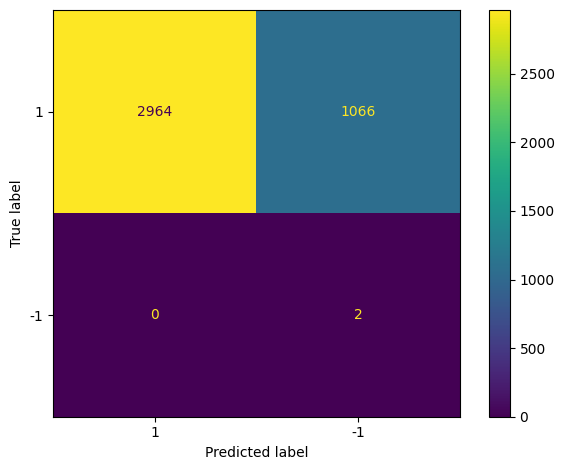

In [98]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df['isAnomaly'], df['baseline'], labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();

plt.grid(False)
plt.tight_layout()

Poor performance by MAD as a consequence of the data not being normalised and majority of the data lies at the median

### Using Isolation Forest

In [99]:
from sklearn.ensemble import IsolationForest

In [113]:
train = df[:3550]
test = df[3550:]
                                          # Change based on DataSet
# train = df[:2000]
# test = df[2000:]

In [114]:
contamination = 1/len(train)

iso_forest = IsolationForest(contamination=contamination, random_state=42)

X_train = train['value'].values.reshape(-1,1)

iso_forest.fit(X_train)

IsolationForest(contamination=0.00028169014084507044, random_state=42)

In [115]:
preds_iso_forest = iso_forest.predict(test['value'].values.reshape(-1,1))

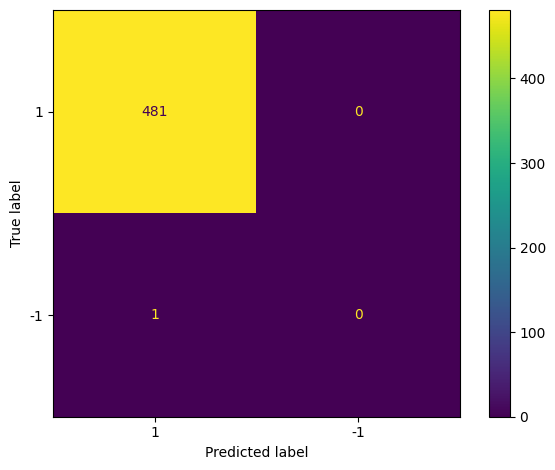

In [116]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test['isAnomaly'], preds_iso_forest, labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();

plt.grid(False)
plt.tight_layout()

Isloation Forest did better in False Positive than MAD did

### Using Local Outlier Factor (LOF)

In [117]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(contamination=contamination, novelty=True)

lof.fit(X_train)

LocalOutlierFactor(contamination=0.00028169014084507044, novelty=True)

In [118]:
preds_lof = lof.predict(test['value'].values.reshape(-1,1))

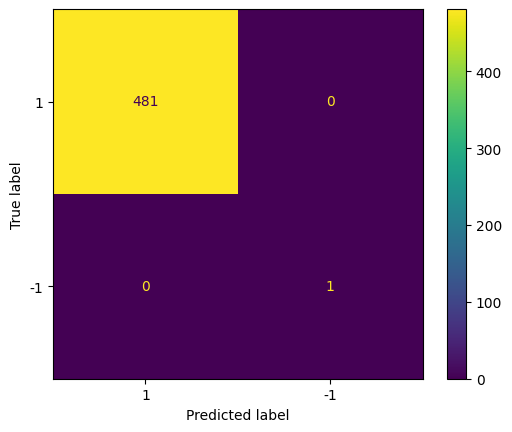

In [119]:
cm = confusion_matrix(test['isAnomaly'], preds_lof, labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();

Best Results we got so far